# Mentoria

In [214]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import emoji
import io
import chardet
from unidecode import unidecode

# detect the laguage of the text in the field mesaage_text
from langdetect import detect, detect_langs
from langdetect import LangDetectException



sns.set(rc={'figure.figsize':(10,6)})
pd.set_option('display.max_rows', 10) # cambiar el número de filas que se mostrarán usando display.max_rows.

In [215]:
src_ds = "data/dataset_diplodatos_corregido.csv"
df = pd.read_csv(src_ds)
df.info()

# Original total: 149859

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150519 entries, 0 to 150518
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                150519 non-null  int64  
 1   commodity         119324 non-null  object 
 2   source_posted_at  150519 non-null  object 
 3   trade_type        141323 non-null  object 
 4   chat_id           150262 non-null  float64
 5   telegram_user_id  150262 non-null  float64
 6   message_text      150519 non-null  object 
dtypes: float64(2), int64(1), object(4)
memory usage: 8.0+ MB


In [216]:
def clean_lbr(text):
    # Replace continuous line breaks with a single line break
    cleaned_text = '\n'.join(line.strip() for line in text.splitlines() if line.strip())
    return cleaned_text

def remove_emojis(text):
    return emoji.replace_emoji(text, '')

def count_line_breaks(text):
    return text.count('\n')

## Limpieza de datos y enriquecimiento
- Sacar los emojis
- Identificar idiomas
    - Adicionar una columna y guardar el dataset
    - Actualizar solo si no existe o se fuerza

- Trim multiple lbrs to ones
- Adicionar message_lbrs
- Adicionar message_length
- Adicionar comodity_in_msg - Pending
- fix date format



In [217]:
force_process = False

if 'message_length' not in df.columns or force_process :
    df['date_source_posted_at'] = pd.to_datetime(df['source_posted_at'])

    # Trim and remove multiple line breaks
    df['message_text_clean'] = df['message_text'].apply(clean_lbr)

    # Eliminar emojis y añadir columna message_no_emoji
    df['message_text_clean'] = df['message_text_clean'].apply(remove_emojis).str.strip().str.lower()

    # Añadir columna con la longitud del mensaje sin emojis
    df['message_length'] = df['message_text_clean'].str.len()

    # Añadir columna con el número de saltos de línea
    df['message_lbr'] = df['message_text_clean'].apply(count_line_breaks)


    # # Detect the encoding of messages in the field message_text_clean of type string\
    df['message_encoding'] = df['message_text_clean'].apply(lambda x: chardet.detect(x.encode())['encoding'])

    
    df['message_text_clean_utf8'] = df['message_text_clean']

    # # convert the all the messages to utf-8 where the encoding is different form utf-8
    flt = df['message_encoding'] != 'utf-8'
    df.loc[flt, 'message_text_clean_utf8'] = df[flt]['message_text_clean'].apply(lambda x: unidecode(x))

    df['message_encoding2'] = df['message_text_clean_utf8'].apply(lambda x: chardet.detect(x.encode())['encoding'])


In [218]:

url = "https://www.unicode.org/Public/security/15.0.0/confusables.txt"
confusables_df = pd.read_csv(url, sep=';', comment='#', header=None, names=['src', 'dst', 'extra'])
confusables_df['src'] = confusables_df['src'].str.strip()
confusables_df['dst'] = confusables_df['dst'].str.strip()

confusables_df = confusables_df[~confusables_df['dst'].str.contains(' ')]
confusables_df["src_char"] = confusables_df["src"].apply(lambda x: chr(int(x, 16)))
confusables_df["dst_char"] = confusables_df["dst"].apply(lambda x: chr(int((x.replace('\t', '')), 16)))

confusables_df['src_enc'] = confusables_df["src"].apply(lambda x: chardet.detect(x.encode())['encoding'])

# exluding the characters that are in utf-8 encoding and ascii encoding
confusables_df = confusables_df[~confusables_df['src_enc'].isin(['utf-8', 'ascii'])]

# export the confusables_df to a python dictionary
confusables_dict = confusables_df.set_index('src_char')['dst_char'].to_dict()



In [219]:
# filter congusables by dst_char = | 
# kk = confusables_df[confusables_df['dst_char'] == 'l']
kk = confusables_df[confusables_df['src_char'] == '1']

# print all rows from the filtered dataframe one by one
for index, row in kk.iterrows():
    enc = chardet.detect(row['src_char'].encode())['encoding']
    enc_dst = chardet.detect(row['dst_char'].encode())['encoding']
    # if enc == 'utf-8' or enc == 'ascii' or enc is None or enc == 'None':  
    #     print(row['src_char'], row['dst_char'], enc, enc_dst)
    print(row['src_char'], row['dst_char'], enc, enc_dst)


In [220]:
def replace_confusables(text):
    return ''.join(confusables_dict.get(char, char) for char in text)

# apply the replace_confusables function to the message_text_clean_utf8 column
df['message_text_clean_utf8_cf'] = df['message_text_clean_utf8'].apply(replace_confusables)


In [221]:
# count the number of messages per encoding
print(df['message_encoding'].value_counts())
print(df['message_encoding2'].value_counts())

message_encoding
ascii           131331
utf-8             8273
Windows-1254      5666
Windows-1252      3745
ISO-8859-1        1125
                 ...  
Johab                5
EUC-JP               4
windows-1253         1
TIS-620              1
GB2312               1
Name: count, Length: 12, dtype: int64
message_encoding2
ascii    142246
utf-8      8273
Name: count, dtype: int64


In [222]:
def detect_language(text):
    try:
        return detect(text)
    except LangDetectException as e:
        print(e, text) 
        return "Unknown"
    else:
        print(e, text)
        return "Error langdetect"

def detect_multiple_languages(text):
    try:
        return detect_langs(text)
    except LangDetectException as e:
        print(e, text) 
        return "Unknown"
    else:
        print(e, text)
        return "Error langdetect"

In [223]:
from pandarallel import pandarallel
pandarallel.initialize()

# df = df.head(10)
if 'language' not in df.columns:
    # df['language'] = df['message_text'].apply(lambda x: detect_language(x) if x is not None else None)
    # df['language'] = df['message_text'].apply(lambda x: detect_language(x) if x is not None else None)
    df['language'] = df['message_text_clean'].parallel_apply(detect_language)
    df.to_csv(src_ds, index=False)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
No features in text. 𝗣𝗿𝗼𝗳𝗲𝘀𝘀𝗶𝗼𝗻𝗮𝗹 𝗠𝗮𝗿𝗸𝗲𝘁𝗶𝗻𝗴
𝗣𝗿𝗼𝗺𝗼𝘁𝗲 𝘆𝗼𝘂𝗿 𝗽𝗿𝗼𝗷𝗲𝗰𝘁
━━━━━━━━━━━━━━━━
𝐓𝐆 𝐒𝐇𝐈𝐋𝐋𝐈𝐍𝐆 𝐒𝐄𝐑𝐕𝐈𝐂𝐄;
𝗦𝗵𝗶𝗹𝗹 𝘆𝗼𝘂𝗿 𝘁𝗼𝗸𝗲𝗻,𝘄𝗲𝗯𝘀𝗶𝘁𝗲,𝗡𝗙𝗧'𝘀,𝗔𝗶𝗿𝗗𝗿𝗼𝗽 𝗼𝗻 +𝟭𝟬𝟬 𝗕𝗲𝘀𝘁 𝗴𝗿𝗼𝘂𝗽𝘀..
- 𝟮𝟰/𝟳 𝗻𝗼𝗻-𝘀𝘁𝗼𝗽, 𝗮𝘂𝘁𝗼𝗺𝗮𝘁𝗶𝗰 𝗽𝗼𝘀𝘁 𝗯𝗼𝘁 𝘀𝗵𝗶𝗹𝗹𝗶𝗻𝗴
- 𝗽𝗲𝗿 𝗯𝗼𝘁 𝘀𝗲𝗻𝗱 𝟭2.𝟬𝟬𝟬 𝗺𝗲𝘀𝘀𝗮𝗴𝗲𝘀 𝗱𝗮𝗶𝗹𝘆
- 𝗽𝗲𝗿 𝗯𝗼𝘁 𝘀𝗲𝗻𝗱 𝟭 𝗺𝗲𝘀𝗮𝗮𝗴𝗲𝘀 𝗲𝗮𝗰𝗵 𝟱 𝘀𝗲𝗰𝗼𝗻𝗱𝘀
𝟭𝟮𝗛: $𝟱𝟬
𝟮𝟰𝗛: $𝟴𝟬
𝟯𝗗: $𝟭𝟬𝟬
𝟭𝗪: $𝟮𝟱𝟬
𝟭𝗠: $𝟱𝟬𝟬
━━━━━━━━━━━━━━━━
𝐃𝐢𝐬𝐜𝐨𝐫𝐝 𝐃𝐌 𝐒𝐡𝐢𝐥𝐥𝐢𝐧𝐠
- 𝗼𝘂𝗿 𝗻𝗲𝘄 𝘀𝗲𝗿𝘃𝗶𝗰𝗲 𝗶𝘀 𝗲𝗳𝗳𝗲𝗰𝘁𝗶𝘃𝗲 𝗮𝗻𝗱 𝗴𝘂𝗮𝗿𝗮𝗻𝘁𝗲𝗲𝗱
- 𝗱𝗮𝗶𝗹𝘆 𝟭𝟬𝗞
𝟭𝗞 𝗗𝗠:$5𝟬
𝟮𝗞 𝗗𝗠:$90
𝟱𝗞 𝗗𝗠:$230
𝟭𝟬𝗞 𝗗𝗠:$300
━━━━━━━━━━━━━━━━
𝑳𝒐𝒈𝒐,𝑺𝒕𝒊𝒄𝒌𝒆𝒓,𝑨𝒏𝒊𝒎𝒂𝒕𝒊𝒐𝒏 𝑽𝒊𝒅𝒆𝒐
𝗟𝗼𝗴𝗼 , 𝗕𝗮𝗻𝗻𝗲𝗿 $3𝟬
𝗦𝘁𝗶𝗰𝗸𝗲𝗿 𝟭𝟬/$2𝟬
𝗔𝗻𝗶𝗺𝗮𝘁𝗶𝗼𝗻 𝗩𝗶𝗱𝗲𝗼 𝟭/$40
━━━━━━━━━━━━━━━━
𝗨𝗽𝘃𝗼𝘁𝗲 𝗦𝗲𝗿𝘃𝗶𝗰𝗲𝘀
- 𝟳 𝗖𝗼𝗶𝗻 𝗩𝗼𝘁𝗲 𝗦𝗶𝘁𝗲'𝘀 (𝗖𝗼𝗶𝗻𝗦𝗻𝗶𝗽𝗲𝗿,𝗖𝗼𝗶𝗻𝗛𝘂𝗻𝘁𝗲𝗿 𝗲𝘁𝗰.)
- 𝗗𝗲𝘁𝗮𝗶𝗹𝘀 𝗗𝗠
- 𝗔𝗹𝗹 𝗩𝗼𝘁𝗲 𝗟𝗶𝘀𝘁𝗲𝗱 $20𝟬
- 𝟱𝟬𝟬 𝗩𝗼𝘁𝗲: $30
- 𝟱𝗞 𝗩𝗼𝘁𝗲: $190
━━━━━━━━━━━━━━━━
━━━━━━━━━━━━━━━━
𝙏𝙂&𝙎𝙘𝙧𝙖𝙥𝙥𝙞𝙣𝙜&𝘿𝙈'𝙨
- 𝗨𝗻𝗹𝗶𝗺𝗶𝘁𝗲𝗱 𝗗𝗠'𝘀
- 𝗨𝗻𝗹𝗶𝗺𝗶𝘁𝗲𝗱 𝗦𝗰𝗿𝗮𝗽𝗽𝗶𝗻𝗴 𝗠𝗲𝗺𝗯𝗲𝗿
- 𝗚𝗿𝗼𝘂𝗽 𝘁𝗼 

In [224]:
df.head(10)

,id,commodity,source_posted_at,trade_type,chat_id,telegram_user_id,message_text,date_source_posted_at,message_text_clean,message_length,message_lbr,message_encoding,message_text_clean_utf8,message_encoding2,message_text_clean_utf8_cf,language
0,2001,DOGE,2022-10-29 17:45:19+00,sell,210.0,977827.0,ByBit USDT\n#DOGE/USDT Cancelled ❌\nTarget ach...,2022-10-29 17:45:19+00:00,bybit usdt\n#doge/usdt cancelled \ntarget achi...,79,2,ascii,bybit usdt\n#doge/usdt cancelled \ntarget achi...,ascii,bybit usdt\n#doge/usdt cancelled \ntarget achi...,da
1,45874,REN,2022-01-15 13:01:43+00,buy,79.0,977825.0,"ByBit USDT, Binance Futures\n#REN/USDT Entry t...",2022-01-15 13:01:43+00:00,"bybit usdt, binance futures\n#ren/usdt entry t...",81,2,ascii,"bybit usdt, binance futures\n#ren/usdt entry t...",ascii,"bybit usdt, binance futures\n#ren/usdt entry t...",en
2,49325,ATA,2022-01-14 21:03:16+00,sell,79.0,977825.0,Binance Futures\n#ATA/USDT Take-Profit target ...,2022-01-14 21:03:16+00:00,binance futures\n#ata/usdt take-profit target ...,93,3,ascii,binance futures\n#ata/usdt take-profit target ...,ascii,binance futures\n#ata/usdt take-profit target ...,en
3,116487,CLV,2022-08-05 09:32:48+00,sell,2.0,848306.0,#CLV here is like a bird out of cage after a l...,2022-08-05 09:32:48+00:00,#clv here is like a bird out of cage after a l...,114,1,Windows-1252,#clv here is like a bird out of cage after a l...,ascii,#clv here is like a bird out of cage after a l...,en
4,468132,SOL,2022-04-03 02:20:32+00,buy,2128.0,1994597.0,TF-V: 5M30S-LLTF-V4\nACCURACY: 91%\nBUY/LONG\n...,2022-04-03 02:20:32+00:00,tf-v: 5m30s-lltf-v4\naccuracy: 91%\nbuy/long\n...,171,12,ascii,tf-v: 5m30s-lltf-v4\naccuracy: 91%\nbuy/long\n...,ascii,tf-v: 5m30s-lltf-v4\naccuracy: 91%\nbuy/long\n...,en
5,33787,VET,2022-06-14 02:05:13+00,sell,79.0,977825.0,"ByBit USDT, Binance Futures\n#VET/USDT All tak...",2022-06-14 02:05:13+00:00,"bybit usdt, binance futures\n#vet/usdt all tak...",117,3,ascii,"bybit usdt, binance futures\n#vet/usdt all tak...",ascii,"bybit usdt, binance futures\n#vet/usdt all tak...",en
6,116491,VITE,2022-08-07 16:36:22+00,buy,2.0,848306.0,We are buying #VITE here\n\nVITE is ready for ...,2022-08-07 16:36:22+00:00,we are buying #vite here\nvite is ready for a ...,157,2,ascii,we are buying #vite here\nvite is ready for a ...,ascii,we are buying #vite here\nvite is ready for a ...,en
7,51223,DOGE,2022-01-24 18:13:34+00,sell,79.0,977825.0,ByBit USDT\n#DOGE/USDT Take-Profit target 2 ✅\...,2022-01-24 18:13:34+00:00,bybit usdt\n#doge/usdt take-profit target 2 \n...,88,3,ascii,bybit usdt\n#doge/usdt take-profit target 2 \n...,ascii,bybit usdt\n#doge/usdt take-profit target 2 \n...,en
8,51225,BAND,2022-01-24 18:14:55+00,sell,79.0,977825.0,Binance Futures\n#BAND/USDT Take-Profit target...,2022-01-24 18:14:55+00:00,binance futures\n#band/usdt take-profit target...,93,3,ascii,binance futures\n#band/usdt take-profit target...,ascii,binance futures\n#band/usdt take-profit target...,en
9,51226,DYDX,2022-01-24 18:15:47+00,sell,79.0,977825.0,"Binance Futures, ByBit USDT\n#DYDX/USDT Take-P...",2022-01-24 18:15:47+00:00,"binance futures, bybit usdt\n#dydx/usdt take-p...",104,3,ascii,"binance futures, bybit usdt\n#dydx/usdt take-p...",ascii,"binance futures, bybit usdt\n#dydx/usdt take-p...",en


In [225]:
# filter df by languages with length > 2
pd.set_option('display.max_rows', 18)
filter = df['language'].str.len() >2
df[filter][['language', 'message_text_clean']]
# configure jupyter to show 18 rows 




,language,message_text_clean
8460,Unknown,https://www.theblockcrypto.com/post/135459/eur...
86250,Unknown,+40%\nhttps://www.tradingview.com/x/epumlmd4/
97472,Unknown,+36%
120281,Unknown,https://www.theblock.co/post/162913/ethereums-...
123496,Unknown,https://thehiddenwiki.com/new-long-v3-onion-se...
132135,Unknown,𝗣𝗿𝗼𝗳𝗲𝘀𝘀𝗶𝗼𝗻𝗮𝗹 𝗠𝗮𝗿𝗸𝗲𝘁𝗶𝗻𝗴\n𝗣𝗿𝗼𝗺𝗼𝘁𝗲 𝘆𝗼𝘂𝗿 𝗽𝗿𝗼𝗷𝗲𝗰𝘁\n...
135700,Unknown,https://m.economictimes.com/industry/services/...
136018,Unknown,https://www.tradingview.com/chart/btcusdt/acci...
136098,Unknown,https://www.tradingview.com/chart/btcusdt/iwnu...
136099,Unknown,https://www.tradingview.com/chart/ethusdt/7f3m...


In [226]:
# Filter messages in english and Unknown
filter = df['language'].isin(['en', 'Unknown'])
df_filtered = df[filter]
df_filtered.info()



<class 'pandas.core.frame.DataFrame'>
Index: 117868 entries, 1 to 150518
Data columns (total 16 columns):
 #   Column                      Non-Null Count   Dtype              
---  ------                      --------------   -----              
 0   id                          117868 non-null  int64              
 1   commodity                   96351 non-null   object             
 2   source_posted_at            117868 non-null  object             
 3   trade_type                  115372 non-null  object             
 4   chat_id                     117612 non-null  float64            
 5   telegram_user_id            117612 non-null  float64            
 6   message_text                117868 non-null  object             
 7   date_source_posted_at       117868 non-null  datetime64[ns, UTC]
 8   message_text_clean          117868 non-null  object             
 9   message_length              117868 non-null  int64              
 10  message_lbr                 117868 non-null  int6

In [227]:
# count the number of messages per encoding
df_filtered['message_encoding'].value_counts()


message_encoding
ascii           104229
utf-8             5231
Windows-1252      3687
Windows-1254      3460
ISO-8859-1         959
ISO-8859-9         272
MacRoman            19
Johab                5
EUC-JP               4
windows-1253         1
GB2312               1
Name: count, dtype: int64

In [228]:
# count null values on field chat_id
df_filtered['chat_id'].isnull().sum()

# give the percentage of null values on field chat_id
df_filtered['chat_id'].isnull().sum() / len(df_filtered) * 100


0.217192113211389

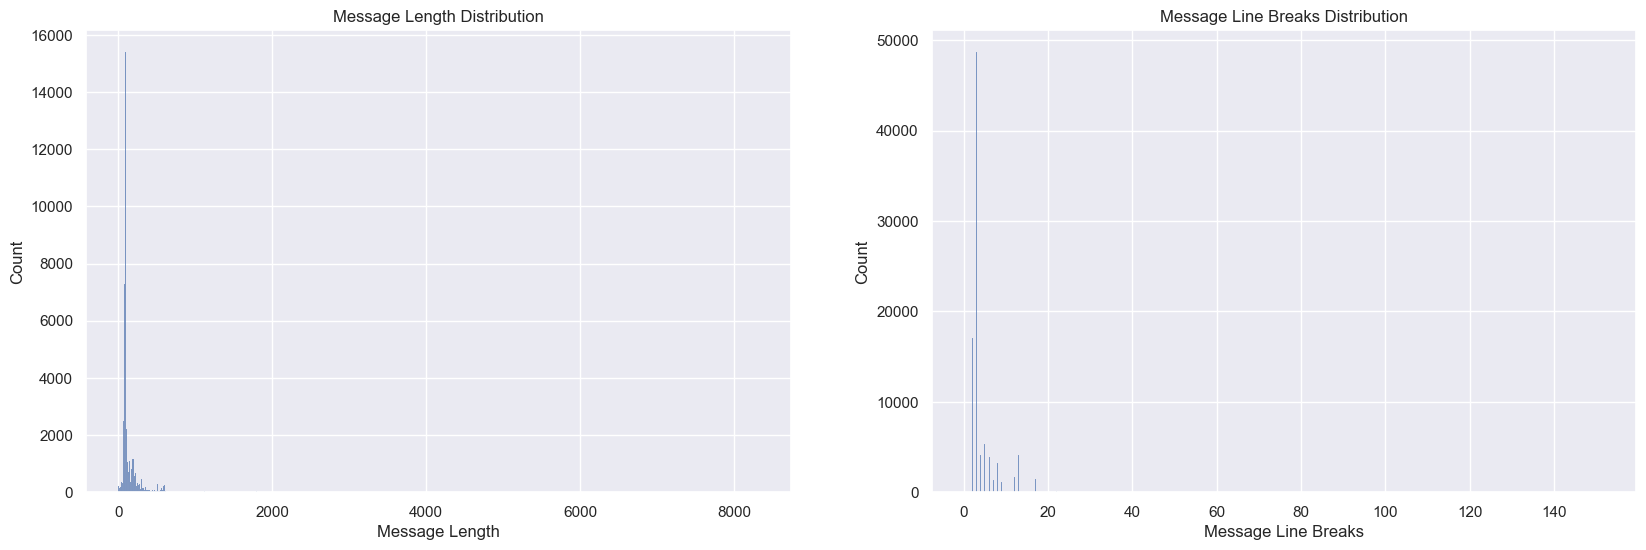

In [229]:
# Generate a distribution plots for message_length and message_lbr
# the plots should one next to the other
# we need to be able to set the size of the plots
# the plots should have a title
# the plots should have labels for the x and y axis

fig, axs = plt.subplots(1, 2, figsize=(20, 6))
sns.histplot(data=df_filtered, x='message_length', ax=axs[0])
axs[0].set_title('Message Length Distribution')
axs[0].set_xlabel('Message Length')
axs[0].set_ylabel('Count')

sns.histplot(data=df_filtered, x='message_lbr', ax=axs[1])
axs[1].set_title('Message Line Breaks Distribution')
axs[1].set_xlabel('Message Line Breaks')
axs[1].set_ylabel('Count')

plt.show()



Hay outlier tanto para message length como para line breaks.
Revisaremos más de cerca los datos con valores abitrarios para hacer un rango más acotado.

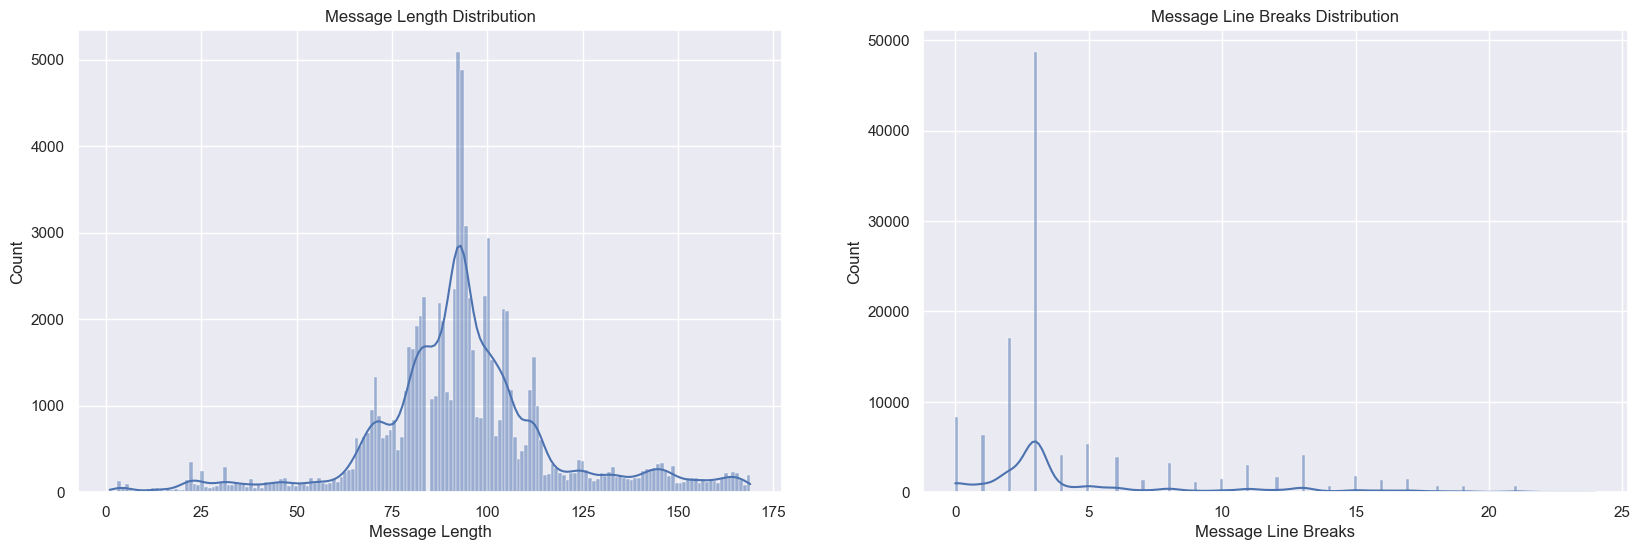

In [230]:
fig, axs = plt.subplots(1, 2, figsize=(20, 6))
flt = df_filtered['message_length'] < 170
sns.histplot(data=df_filtered[flt], x='message_length', ax=axs[0], kde=True)
# sns.histplot(df_filtered[flt]['message_length'], bins=100, kde=True)
axs[0].set_title('Message Length Distribution')
axs[0].set_xlabel('Message Length')
axs[0].set_ylabel('Count')

flt = df_filtered['message_lbr'] < 25
sns.histplot(data=df_filtered[flt], x='message_lbr', ax=axs[1], kde=True)
# sns.histplot(['message_lbr'], bins=100, kde=True)
axs[1].set_title('Message Line Breaks Distribution')
axs[1].set_xlabel('Message Line Breaks')
axs[1].set_ylabel('Count')

plt.show()


Total filtered: 87309, 58.01%


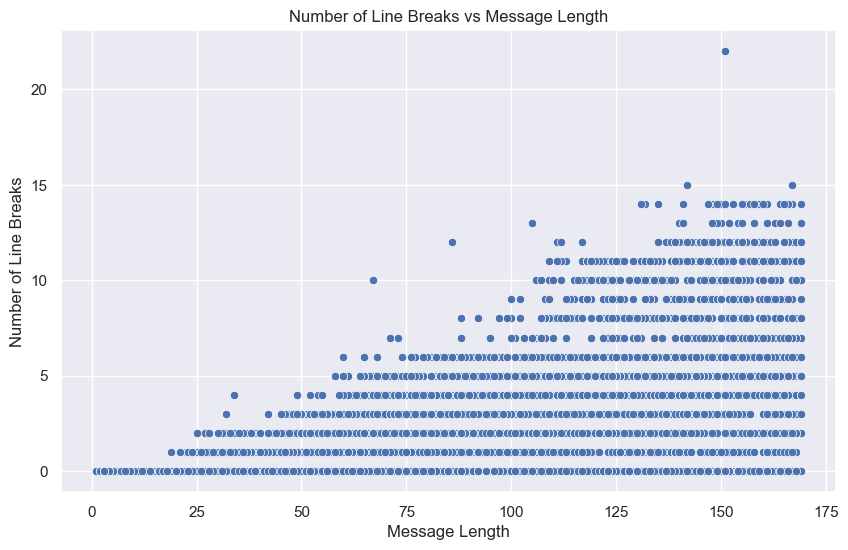

In [231]:
# Generate a distribution plot of the number of line breaks cross message length (scatter plot)
# flt = df['message_length'] < 3170
flt = (df_filtered['message_lbr'] < 25) & (df_filtered['message_length'] < 170)
total_filtered = len(df_filtered[flt])
print(f"Total filtered: {total_filtered}, {total_filtered/len(df):.2%}")

sns.scatterplot(data=df_filtered[flt], x='message_length', y='message_lbr')
plt.xlabel('Message Length')
plt.ylabel('Number of Line Breaks')
plt.title('Number of Line Breaks vs Message Length')
plt.show()


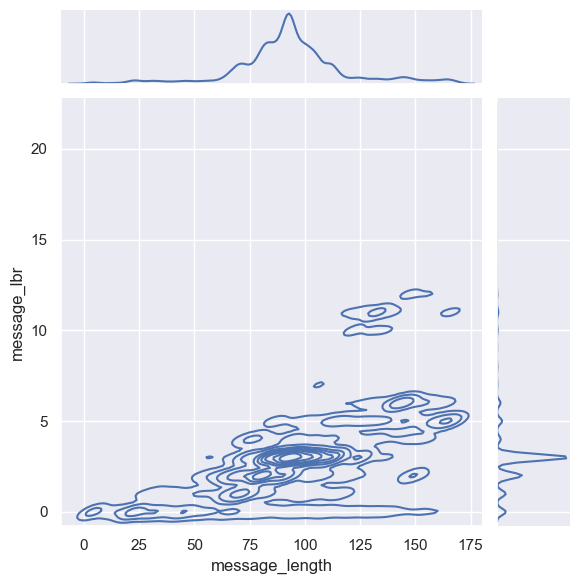

In [232]:
# TODO: Understand KDE plot and how to use it
g = sns.jointplot(data=df_filtered[flt], x='message_length', y='message_lbr', kind='kde')
plt.show()

In [233]:
# Look for possible tokes.
# message_field = "message_text_clean"
message_field = "message_text_clean_utf8_cf"
# generate a new dataframe that has each line of the messages as a row and keep the index of the original message
df_messages = df_filtered[message_field].str.split('\n').explode().reset_index()

# add a column with the length of each message
df_messages['message_length'] = df_messages[message_field].str.len()


# split the messages by : and add a column with the first part of the message
flt = df_messages[message_field].str.contains(':')
df_messages['message_text_clean_split'] = df_messages[flt][message_field].str.split(':').str[0].str.strip().str.lower()



In [234]:
# Get the list of tokens message_text_clean_split and the count as a dataframe
tokens = df_messages['message_text_clean_split'].value_counts()
tokens = tokens.reset_index()
tokens.columns = ['token', 'count']

# filter tokens with count > 2
flt = (tokens['count'] > 50)

print(tokens[flt].describe())

#print the tokens descending by count
print(tokens[flt])

# # sum of count
# tokens[flt]['count'].sum()

#export the tokens to a csv file on data folder, sorted by token
token_file = 'data/tokens3.csv'
tokens[flt].sort_values('token').to_csv(token_file, index=False, sep='|')


              count
count    147.000000
mean    1746.809524
std     5810.796027
min       53.000000
25%       96.500000
50%      251.000000
75%     1181.500000
max    47610.000000
                                                 token  count
0                                               period  47610
1                                               profit  46970
2                                             leverage  15430
3                                                https  11016
4                                  average entry price  10086
..                                                 ...    ...
142                                              price     56
143                                            revenue     56
144  remember our pump instructions and remember th...     54
145                                        entry range     54
146                                                  5     53

[147 rows x 2 columns]


In [235]:
token_mappping = [
["#coin", "coin"],
["#duration", "duration"],
["#period", "period"],
["#profit", "profit"],
["accuracy", "accuracy"],
["accuracy is", "accuracy"],
["advantage", "advantage"],
["amount", "amount"],
["average entry price", "average-entry-price"],
["buy", "buy"],
["buy range", "buy-zone"],
["buy zone", "buy-zone"],
["caption", "Rev"],
["coin", "coin"],
["coin is", "coin"],
["coin name", "coin"],
["country", "Rev"],
["current high", "current-high"],
["date", "Rev"],
["deposit", "Rev"],
["direction", "Rev"],
["duration", "duration"],
["entries", "entry"],
["entry", "entry"],
["entry 1", "entry-n"],
["entry 2", "entry-n"],
["entry below", "entry"],
["entry price", "entry-price"],
["entry range", "entry-range"],
["entry target", "entry-target"],
["entry targets", "entry-target"],
["entry targts", "entry-target"],
["entry zone", "entry-zone"],
["exchange", "exchange"],
["exchanges", "exchange"],
["exhange", "exchange"],
["leverage", "leverage"],
["long", "long"],
["long below", "long"],
["lower limit", "lower-limit"],
["manual stop", "manual-stop"],
["margin", "margin"],
["mark price", "mark-price"],
["max leverage", "max-leverage"],
["mid term targets", "mid-term-targets"],
["pair", "Rev"],
["pairing", "Rev"],
["payment _method", "payment-method"],
["period", "period"],
["plan", "Rev"],
["platform", "platform"],
["price", "price"],
["profit", "profit"],
["profit by signal", "profit"],
["profit targets", "profit"],
["revenue", "revenue"],
["sell", "sell"],
["short", "short"],
["short above", "?"],
["short term targets", "short-term-targets"],
["signal type", "signal-type"],
["sl", "sl-rev"],
["start price", "st-price"],
["starting", "starting?"],
["stop", "stop"],
["stop loss", "stop-loss"],
["stop target", "stop-target"],
["stop targets", "stop-target"],
["stop-loss", "stop-loss"],
["stop-loss orders", "stop-loss"],
["stoploss", "stop-loss"],
["take profit", "take-profit"],
["take profit 1", "take-profit-n"],
["take profit 2", "take-profit-n"],
["take profit 3", "take-profit-n"],
["take profit 4", "take-profit-n"],
["take profit 5", "take-profit-n"],
["take profit targets", "take-profit"],
["take-profit orders", "take-profit"],
["take-profit targets", "take-profit"],
["target", "target"],
["target 1", "target-n"],
["target 2", "target-n"],
["target 3", "target-n"],
["target 4", "target-n"],
["target 5", "target-n"],
["target 6", "target-n"],
["target 7", "target-n"],
["target 8", "target-n"],
["targets", "target"],
["targets achieved", "Rev"],
["targets usdt", "target?"],
["tf-v", "?"],
["ticker", "ticker"],
["time", "time?"],
["total profit", "total-profit"],
["tp", "tp"],
["tp1", "tpn"],
["tp2", "tpn"],
["tp3", "tpn"],
["tp4", "tpn"],
["tp5", "tpn"],
["tp6", "tpn"],
["trade type", "trade-type"],
["trading pair", "trading-pair"],
["trailing configuration", "Rev"],
["trigger", "trigger"],
["type", "type"],
["up zones", "Rev"],
["upper limit", "upper-limit"],
["ехсhanges", "ехсhange"],
]

In [236]:
import re

# generate a dataframe from token_mapping
df_token_mapping = pd.DataFrame(token_mappping, columns=['token_src', 'token'])

# add curly braces to the token
df_token_mapping['token'] = '{{' + df_token_mapping['token'] + '}}'



# add token length
df_token_mapping['token_src_length'] = df_token_mapping['token_src'].str.len()

# sort df_token_mapping by token_mapping and then length of token in descending order
df_token_mapping = df_token_mapping.sort_values(['token', 'token_src_length'], ascending=[True, False])

token_mapping = df_token_mapping[['token_src', 'token']].values.tolist()

base_patterns = [
    (r'\d{4}-\d{2}-\d{2}', '{{DATE}}'),
    (r'\d+\.\d+', '{{DECIMAL}}'),
    (r'\d+', '{{NUMBER}}'),
    (r'\$', '{{DOLLAR}}'),
    (r'[a-zA-Z]+', '{{WORD}}'),
    # (r'\w+', 'WORD'),
]

# add the base_patterns to the token_mapping
patterns = token_mapping + base_patterns

input_string = """tp1 tp 123 2021-10-10  $
123.45 hello tp take profit  target target 1
take profit tp2
take profit 1 take profit 2 tp1 tp2
"""



def process_chunk(chunk, patterns):
    for pattern in patterns:
        new_chunk = re.sub(pattern[0], pattern[1], chunk)
        if new_chunk != chunk:
            # reprocess the new_chunk
            return process_line(new_chunk, patterns)
    return chunk

def process_line(line, patterns):
    pattern_token = r'(\{\{.*?\}\})'
    parts = re.split(pattern_token, line)
    for i, part in enumerate(parts):
        if not re.match(pattern_token, part):
            parts[i] = process_chunk(part, patterns)
    return "".join(parts)

def simple_tokenizer2(text, patterns=patterns):
    lines = text.split('\n')
    processed_lines = [process_line(line, patterns) for line in lines]
    return '\n'.join(processed_lines)
    


In [237]:
msg_tpl = simple_tokenizer2(input_string, patterns) 
print(msg_tpl)

msg_tpl2 = simple_tokenizer2(input_string, token_mapping)
print(msg_tpl2)

{{tpn}} {{tp}} {{NUMBER}} {{DATE}}  {{DOLLAR}}
{{DECIMAL}} {{WORD}} {{tp}} {{WORD}} {{profit}}  {{target}} {{target-n}}
{{WORD}} {{profit}} {{tpn}}
{{WORD}} {{profit}} {{NUMBER}} {{WORD}} {{profit}} {{NUMBER}} {{tpn}} {{tpn}}

{{tpn}} {{tp}} 123 2021-10-10  $
123.45 hello {{tp}} take {{profit}}  {{target}} {{target-n}}
take {{profit}} {{tpn}}
take {{profit}} 1 take {{profit}} 2 {{tpn}} {{tpn}}



In [238]:
# how to apply a function with two params to a column and get the result in a new column
df_filtered['msg_tpl'] = df_filtered.parallel_apply(lambda x: simple_tokenizer2(x['message_text_clean_utf8_cf'], patterns), axis=1)



/var/folders/c1/5sw0mcxn0s5891c6173ck1sw0000gq/T/ipykernel_82724/3954910034.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['msg_tpl'] = df_filtered.parallel_apply(lambda x: simple_tokenizer2(x['message_text_clean_utf8_cf'], patterns), axis=1)


In [253]:
# add a field with a hash of the msg_tpl
df_filtered['msg_tpl_hash'] = df_filtered['msg_tpl'].apply(hash)


/var/folders/c1/5sw0mcxn0s5891c6173ck1sw0000gq/T/ipykernel_82724/113111668.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['msg_tpl_hash'] = df_filtered['msg_tpl'].apply(hash)


In [254]:
# count messages by msg_tpl
msg_tpl_count = df_filtered['msg_tpl_hash'].value_counts()


msg_tpl_count = msg_tpl_count.reset_index()
msg_tpl_count.columns = ['msg_tpl_hash', 'count']
msg_tpl_count = msg_tpl_count.sort_values('count', ascending=False)

# add a column with accumulated count
msg_tpl_count['accumulated'] = msg_tpl_count['count'].cumsum()

# add a column with the percentage of the accumulated count
msg_tpl_count['accumulated_percentage'] = msg_tpl_count['accumulated'] / msg_tpl_count['count'].sum()


In [255]:
msg_tpl_count.describe()

,msg_tpl_hash,count,accumulated,accumulated_percentage
count,1.934700e+04,19347.000000,19347.000000,19347.000000
mean,1.657316e+16,6.092314,106758.262883,0.905744
std,5.339404e+18,151.972860,8515.304639,0.072244
min,-9.222607e+18,1.000000,15971.000000,0.135499
25%,-4.605649e+18,1.000000,102873.000000,0.872781
50%,2.604944e+16,1.000000,108195.000000,0.917934
75%,4.655476e+18,2.000000,113031.500000,0.958967
max,9.222986e+18,15971.000000,117868.000000,1.000000


In [250]:
msg_tpl_count.info()


<class 'pandas.core.frame.DataFrame'>
Index: 19347 entries, 0 to 19346
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   msg_tpl                 19347 non-null  object 
 1   count                   19347 non-null  int64  
 2   msg_tpl_hash            19347 non-null  int64  
 3   accumulated             19347 non-null  int64  
 4   accumulated_percentage  19347 non-null  float64
dtypes: float64(1), int64(3), object(1)
memory usage: 906.9+ KB


In [256]:
# filter by accumulated_percentage < 0.95
flt = msg_tpl_count['accumulated_percentage'] < 0.5
msg_tpl_count[flt]


,msg_tpl_hash,count,accumulated,accumulated_percentage
0,2850279357081776162,15971,15971,0.135499
1,-3139747619129098963,10569,26540,0.225167
2,-830115115626369508,4149,30689,0.260368
3,-2023540413550803653,3949,34638,0.293871
4,-1579739535412387361,3790,38428,0.326026
...,...,...,...,...
17,-1041887356899344213,677,56250,0.477229
18,3841733889476949416,646,56896,0.482709
19,-1659256894533145548,631,57527,0.488063
20,8107724616359697214,629,58156,0.493399


In [267]:


# , 'msg_tpl']


{{WORD}} {{WORD}}, {{WORD}} {{WORD}}
#{{WORD}}/{{WORD}} {{entry-target}} {{NUMBER}} 
{{average-entry-price}}: {{DECIMAL}}


In [269]:
# list messages with the same msg_tpl_hash = 2850279357081776162
flt = df_filtered['msg_tpl_hash'] == 2850279357081776162
# flt = df_filtered['msg_tpl_hash'] == -3139747619129098963
df_filtered[flt][['message_text_clean', 'msg_tpl']].head(10)
# loop on the filtered dataframe and print the message_text_clean and msg_tpl

print('####################')
print('##### TEMPLATE #####')
print('####################')

print(df_filtered.iloc[0]['msg_tpl'])

print('----- MESSAGES -----')
# print the field msg_tpl for the first row of the filtered dataframe as a string
for index, row in df_filtered[flt].head(3).iterrows():
    print(row['message_text_clean'])
    print('------------------')
    


####################
##### TEMPLATE #####
####################
{{WORD}} {{WORD}}, {{WORD}} {{WORD}}
#{{WORD}}/{{WORD}} {{entry-target}} {{NUMBER}} 
{{average-entry-price}}: {{DECIMAL}}
----- MESSAGES -----
binance futures
#ata/usdt take-profit target 2 
profit: 31.7664% 
period: 20 hours 16 minutes
------------------
bybit usdt
#doge/usdt take-profit target 2 
profit: 62.2568% 
period: 6 hours 56 minutes
------------------
binance futures
#band/usdt take-profit target 3 
profit: 81.9581% 
period: 6 hours 56 minutes
------------------


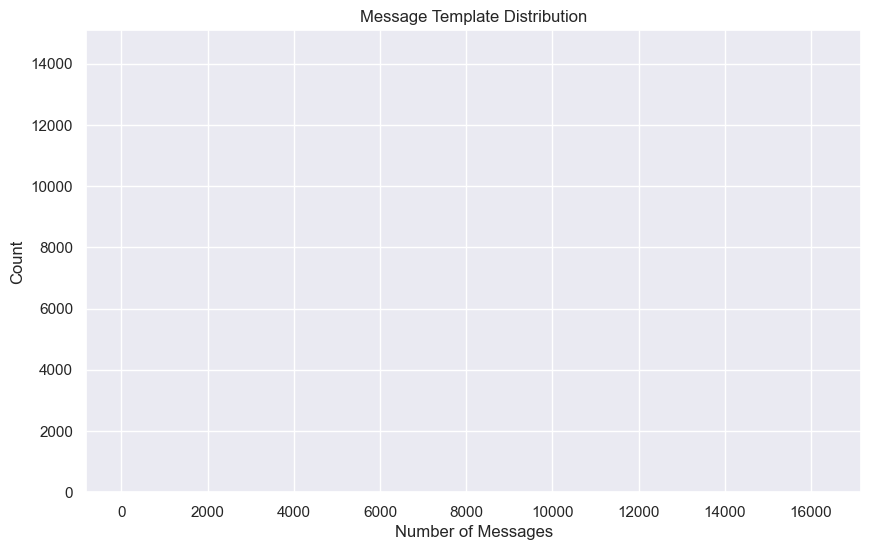

In [ ]:
# graph the distribution of the messages count by msg_tpl
sns.histplot(data=msg_tpl_count, x='count')
plt.xlabel('Number of Messages')
plt.ylabel('Count')
plt.title('Message Template Distribution')
plt.show()


- Largo de mensje y tiempo
- Exchage?
- Falsos positivos en comodity - Filtrado de datos
- Correlaciones a encontrar
    - Por usr
    - Por mensaje repetido across channels
- Lista de TOKENS - Cuales nos interesan?
- split de mensajes en por tiempo y numero de usuarios
    - tener la lista de users 
- users más activos
- users asociados a monedas

- Por el momento una señal es un mensaje
- Envento - comversación alrededor de una moneda
    - inicio - fin
    - inicio - msg que inicia a  hablar de una moneda
    - fin, silencio por 24 hrs


Clusters 

Similitud de mensajes
Poder decir que canales son similares
Que usuarios son similares
Que usuarios son bots
    Mensajes 

Monedas por canal
Monedas por user
